### Import tensorflow and relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm

### Load the dataset

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, ds_path, transforms=None, target_transform=None):
        self.ds_path = ds_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.labels = os.listdir(ds_path)
        img_paths = []
        
        for i in self.labels:
            base_path = os.path.join(ds_path, i)
            imgs = os.listdir(base_path)
            for img in imgs:
                img_path = base_path + '/' + img
                img_paths.append(img_path)
                
        self.img_paths = img_paths
        self.label_map = {'CNV':0, 'DME':1, 'DRUSEN':2, 'NORMAL':3,}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        label = img_path.split('/')[-2]
        image = image.squeeze()
        image = image.repeat(3, 1, 1)
        image = image / 255.0
        if self.transforms:
            image = self.transforms(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        image = T.Resize((224, 224))(image)
        
        return image, self.label_map[label]

In [3]:
# Load training dataset
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
train_data = CustomImageDataset(train_path)

# Load validation dataset
val_path = '/kaggle/input/kermany2018/OCT2017 /val'
val_data = CustomImageDataset(val_path)

# Load test dataset
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
test_data = CustomImageDataset(test_path)

In [4]:
from torch.utils.data import DataLoader

train_len = len(train_data)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

val_len = len(val_data)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

test_len = len(test_data)
test_dataloader = DataLoader(test_data, batch_size=8)

data_loaders = {'train':train_dataloader, 'val':val_dataloader}

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


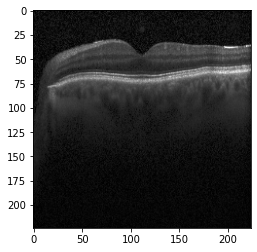

Label: 3


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Create Training function

In [7]:
def train_model(model, criterion, optimizer, num_epochs=3):
    since = time.time()
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for mode, data_loader in data_loaders.items():
            if mode == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct = 0

            # Iterate over batches
            for inputs, labels in tqdm(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if mode == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds==labels.data)
            
            data_len = train_len
            
            if mode == 'val':
                data_len = val_len
            
            epoch_loss = running_loss / data_len
            epoch_acc = running_correct.double() / data_len

            print('{} loss: {:4f} acc: {:4f}'.format(mode, epoch_loss, epoch_acc))
        
    

## Defining model

In [8]:
train_len, val_len, test_len

(83484, 32, 968)

In [9]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------


100%|██████████| 1305/1305 [16:47<00:00,  1.30it/s]


train loss: 0.197729 acc: 0.934407


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


val loss: 0.161058 acc: 0.906250
Epoch 2/10
----------


100%|██████████| 1305/1305 [10:04<00:00,  2.16it/s]


train loss: 0.133178 acc: 0.954566


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


val loss: 0.075461 acc: 1.000000
Epoch 3/10
----------


100%|██████████| 1305/1305 [09:54<00:00,  2.20it/s]


train loss: 0.109112 acc: 0.962915


100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


val loss: 0.045358 acc: 0.968750
Epoch 4/10
----------


100%|██████████| 1305/1305 [09:38<00:00,  2.25it/s]


train loss: 0.094107 acc: 0.967539


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


val loss: 0.027706 acc: 1.000000
Epoch 5/10
----------


100%|██████████| 1305/1305 [09:57<00:00,  2.18it/s]


train loss: 0.076797 acc: 0.973157


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


val loss: 0.043634 acc: 0.968750
Epoch 6/10
----------


100%|██████████| 1305/1305 [09:57<00:00,  2.19it/s]


train loss: 0.063644 acc: 0.977972


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


val loss: 0.028500 acc: 1.000000
Epoch 7/10
----------


100%|██████████| 1305/1305 [09:52<00:00,  2.20it/s]


train loss: 0.053975 acc: 0.980942


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


val loss: 0.010490 acc: 1.000000
Epoch 8/10
----------


100%|██████████| 1305/1305 [09:53<00:00,  2.20it/s]


train loss: 0.043672 acc: 0.985111


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


val loss: 0.005956 acc: 1.000000
Epoch 9/10
----------


100%|██████████| 1305/1305 [10:04<00:00,  2.16it/s]


train loss: 0.037629 acc: 0.987147


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


val loss: 0.014543 acc: 1.000000
Epoch 10/10
----------


100%|██████████| 1305/1305 [09:53<00:00,  2.20it/s]


train loss: 0.034859 acc: 0.987279


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

val loss: 0.002767 acc: 1.000000


In [11]:
running_loss = 0.0
running_correct = 0

# Iterate over batches
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_correct += torch.sum(preds==labels.data)
    
epoch_loss = running_loss / test_len
epoch_acc = running_correct.double() / test_len

print('{} loss: {:4f} acc: {:4f}'.format('test', epoch_loss, epoch_acc))

100%|██████████| 121/121 [00:09<00:00, 12.92it/s]

test loss: 0.012862 acc: 0.996901
